# BO with `ax_platform=0.4.3`

In [ ]:
import asyncio
import numpy as np
import torch
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.acquisition import qNegIntegratedPosteriorVariance
from botorch.models.gp_regression import SingleTaskGP
from ax.service.utils.instantiation import ObjectiveProperties
import random
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np

SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

class ZReader:
    """Fake response for testing purposes."""
    def __init__(self, centers, sigma=0.1, n_samples=1):
        """
        Initialize the Gaussian response surface.

        Args:
            centers (list): Centers of the Gaussian for each parameter.
            sigma (float): Standard deviation of the Gaussian.
            n_samples (int): Number of samples to compute mean and SEM.
        """
        self.centers = np.array(centers)
        self.sigma = sigma
        self.n_samples = n_samples

    def read(self, params):
        """
        Compute the Gaussian response and optionally SEM.

        Args:
            params (list): List of parameter values.

        Returns:
            tuple: (mean, sem) if n_samples > 1 else (z, 0.0).
        """
        params = np.array(params)
        z = np.exp(-np.sum((params - self.centers) ** 2) / (2 * self.sigma ** 2))
        if self.n_samples > 1:
            noisy_z = [z + np.random.normal(0, self.sigma) for _ in range(self.n_samples)]
            mean_z = np.mean(noisy_z)
            sem_z = np.std(noisy_z) / np.sqrt(self.n_samples)
            return mean_z, sem_z
        return z, 0.0


async def get_next_batch_async(ax_client, batch_size):
    """Fetch the next batch of trials asynchronously."""
    loop = asyncio.get_event_loop()
    return await asyncio.gather(
        *[loop.run_in_executor(None, ax_client.get_next_trial) for _ in range(batch_size)]
    )


async def complete_trial_async(ax_client, trial_index, result):
    """Complete a trial asynchronously."""
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(None, ax_client.complete_trial, trial_index, result)


async def bayesian_optimizer_iterator(
    z_reader,
    param_names,
    param_bounds,
    num_initial_samples=10,
    num_bo_samples=20,
    batch_size=1,
    explore_ratio=0.1,
    async_mode=True
):
    """
    Bayesian optimizer iterator that can run asynchronously or synchronously depending on `async_mode`.

    Args:
        z_reader: An object with a `.read()` method to fetch the latest objective value.
        param_names (list): Names of the input parameters.
        param_bounds (list of tuples): Bounds for each parameter (min, max).
        num_initial_samples (int): Number of initial Sobol samples.
        num_bo_samples (int): Total number of Bayesian optimization samples.
        batch_size (int): Number of trials generated in each batch.
        explore_ratio (float): Probability of using qNIPV for exploration.
        async_mode (bool): If True, use asynchronous operations, else synchronous.

    Yields:
        dict: A dictionary of parameter values to evaluate.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(model=Models.GPEI, num_trials=-1, max_parallelism=batch_size),
        ]
    )
    ax_client = AxClient(generation_strategy=generation_strategy, torch_device=device)
    ax_client.create_experiment(
        name="modular_iterator_optimization",
        parameters=[
            {"name": name, "type": "range", "bounds": bounds}
            for name, bounds in zip(param_names, param_bounds)
        ],
        objectives={"z": ObjectiveProperties(minimize=False)},
        parameter_constraints=[],
        tracking_metric_names=[],
    )

    # Helper functions to abstract async/sync behavior
    async def get_next_batch(ax_client, b_size):
        if async_mode:
            return await get_next_batch_async(ax_client, b_size)
        else:
            return [ax_client.get_next_trial() for _ in range(b_size)]

    async def complete_trial(ax_client, t_index, res):
        if async_mode:
            return await complete_trial_async(ax_client, t_index, res)
        else:
            return ax_client.complete_trial(t_index, res)

    # Initial Sobol samples
    for _ in range(num_initial_samples):
        trials = await get_next_batch(ax_client, 1)
        params, trial_index = trials[0]
        yield params
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        await complete_trial(ax_client, trial_index, {"z": (z_mean, z_sem)})

    # Bayesian optimization loop
    remaining_samples = num_bo_samples
    while remaining_samples > 0:
        current_batch_size = min(batch_size, remaining_samples)

        # Decide between exploration (qNIPV) and exploitation (GPEI)
        explore = np.random.rand() < explore_ratio
        if explore:
            print("Using qNIPV (Exploration)")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 50},
            }
        else:
            print("Using GPEI (Exploitation)")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
            ax_client.generation_strategy._steps[-1].model_kwargs = {}

        trials = await get_next_batch(ax_client, current_batch_size)

        for params, trial_index in trials:
            yield params
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            await complete_trial(ax_client, trial_index, {"z": (z_mean, z_sem)})

        remaining_samples -= current_batch_size


def bayesian_optimizer_iterator_sync(
    z_reader,
    param_names,
    param_bounds,
    num_initial_samples=10,
    num_bo_samples=20,
    batch_size=1,
    explore_ratio=0.1
):
    """
    Synchronous Bayesian optimizer iterator.

    Identical logic to bayesian_optimizer_iterator, but runs without async/await.

    Args:
        z_reader: An object with a `.read()` method to fetch the latest objective value.
        param_names (list): Names of the input parameters.
        param_bounds (list of tuples): Bounds for each parameter (min, max).
        num_initial_samples (int): Number of initial Sobol samples.
        num_bo_samples (int): Total number of Bayesian optimization samples.
        batch_size (int): Number of trials generated in each batch.
        explore_ratio (float): Probability of using qNIPV for exploration.

    Yields:
        dict: A dictionary of parameter values to evaluate.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(model=Models.GPEI, num_trials=-1, max_parallelism=batch_size),
        ]
    )
    ax_client = AxClient(generation_strategy=generation_strategy, torch_device=device)
    ax_client.create_experiment(
        name="modular_iterator_optimization_sync",
        parameters=[
            {"name": name, "type": "range", "bounds": bounds}
            for name, bounds in zip(param_names, param_bounds)
        ],
        objectives={"z": ObjectiveProperties(minimize=False)},
        parameter_constraints=[],
        tracking_metric_names=[],
    )

    # Initial Sobol samples (synchronous)
    for _ in range(num_initial_samples):
        params, trial_index = ax_client.get_next_trial()
        yield params
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        ax_client.complete_trial(trial_index, {"z": (z_mean, z_sem)})

    # Bayesian optimization loop (synchronous)
    remaining_samples = num_bo_samples
    while remaining_samples > 0:
        current_batch_size = min(batch_size, remaining_samples)

        # Decide between exploration (qNIPV) and exploitation (GPEI)
        explore = np.random.rand() < explore_ratio
        if explore:
            print("Using qNIPV (Exploration)")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 50},
            }
        else:
            print("Using GPEI (Exploitation)")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
            ax_client.generation_strategy._steps[-1].model_kwargs = {}

        # Generate trials synchronously
        for _ in range(current_batch_size):
            params, trial_index = ax_client.get_next_trial()
            yield params
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            ax_client.complete_trial(trial_index, {"z": (z_mean, z_sem)})

        remaining_samples -= current_batch_size




[INFO 12-13 23:40:16] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:40:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:40:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:40:16] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='a', parameter_type=FLOAT, range=[-1.0, 1.0]), RangeParameter(name='b', parameter_type=FLOAT, range=[-1.0, 1.0])], parameter_constraints=[]).
[INFO 12-13 23:40:16]

Using GPEI (Exploitation)


[INFO 12-13 23:40:17] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.28153, 'b': 0.132042} using model GPEI.
[INFO 12-13 23:40:17] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.281201, 'b': 0.132099} using model GPEI.
[INFO 12-13 23:40:17] ax.service.ax_client: Completed trial 20 with data: {'z': (0.681341, 0.0)}.
[INFO 12-13 23:40:17] ax.service.ax_client: Completed trial 21 with data: {'z': (0.683044, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:40:18] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.232324, 'b': 0.141167} using model GPEI.
[INFO 12-13 23:40:18] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.281613, 'b': 0.132028} using model GPEI.
[INFO 12-13 23:40:18] ax.service.ax_client: Completed trial 22 with data: {'z': (0.871989, 0.0)}.
[INFO 12-13 23:40:18] ax.service.ax_client: Completed trial 23 with data: {'z': (0.680914, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:19] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.23245, 'b': 0.141128} using model GPEI.
[INFO 12-13 23:40:19] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.186163, 'b': 0.148895} using model GPEI.
[INFO 12-13 23:40:19] ax.service.ax_client: Completed trial 25 with data: {'z': (0.878879, 0.0)}.
[INFO 12-13 23:40:19] ax.service.ax_client: Completed trial 24 with data: {'z': (0.871775, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:19] ax.service.ax_client: Generated new trial 26 with parameters {'a': -0.263885, 'b': -1.0} using model GPEI.
[INFO 12-13 23:40:20] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.207986, 'b': 0.19057} using model GPEI.
[INFO 12-13 23:40:20] ax.service.ax_client: Completed trial 26 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:40:20] ax.service.ax_client: Completed trial 27 with data: {'z': (0.66144, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:20] ax.service.ax_client: Generated new trial 28 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:40:20] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.199857, 'b': 0.102589} using model GPEI.
[INFO 12-13 23:40:20] ax.service.ax_client: Completed trial 29 with data: {'z': (0.999664, 0.0)}.
[INFO 12-13 23:40:20] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:21] ax.service.ax_client: Generated new trial 30 with parameters {'a': 1.0, 'b': 0.529499} using model GPEI.
[INFO 12-13 23:40:21] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.199862, 'b': 0.10261} using model GPEI.
[INFO 12-13 23:40:21] ax.service.ax_client: Completed trial 31 with data: {'z': (0.999658, 0.0)}.
[INFO 12-13 23:40:21] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:22] ax.service.ax_client: Generated new trial 32 with parameters {'a': -1.0, 'b': 0.208541} using model GPEI.
[INFO 12-13 23:40:23] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.189151, 'b': 0.094558} using model GPEI.
[INFO 12-13 23:40:23] ax.service.ax_client: Completed trial 33 with data: {'z': (0.992661, 0.0)}.
[INFO 12-13 23:40:23] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:24] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.013081, 'b': -0.059096} using model GPEI.
[INFO 12-13 23:40:24] ax.service.ax_client: Generated new trial 35 with parameters {'a': -0.308646, 'b': 0.552493} using model GPEI.
[INFO 12-13 23:40:24] ax.service.ax_client: Completed trial 34 with data: {'z': (0.049168, 0.0)}.
[INFO 12-13 23:40:24] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:25] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.267819, 'b': 1.0} using model GPEI.
[INFO 12-13 23:40:25] ax.service.ax_client: Generated new trial 37 with parameters {'a': -0.306928, 'b': 0.552111} using model GPEI.
[INFO 12-13 23:40:25] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:40:25] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:26] ax.service.ax_client: Generated new trial 38 with parameters {'a': 1.0, 'b': -0.257797} using model GPEI.
[INFO 12-13 23:40:26] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.203953, 'b': 0.095164} using model GPEI.
[INFO 12-13 23:40:26] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:40:26] ax.service.ax_client: Completed trial 39 with data: {'z': (0.998051, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:27] ax.service.ax_client: Generated new trial 40 with parameters {'a': 1.0, 'b': -0.257625} using model GPEI.
[INFO 12-13 23:40:27] ax.service.ax_client: Generated new trial 41 with parameters {'a': -1.0, 'b': -0.551335} using model GPEI.
[INFO 12-13 23:40:27] ax.service.ax_client: Completed trial 40 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:40:27] ax.service.ax_client: Completed trial 41 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:28] ax.service.ax_client: Generated new trial 42 with parameters {'a': 0.248222, 'b': -0.368134} using model GPEI.
[INFO 12-13 23:40:28] ax.service.ax_client: Generated new trial 43 with parameters {'a': -1.0, 'b': -0.551346} using model GPEI.
[INFO 12-13 23:40:28] ax.service.ax_client: Completed trial 42 with data: {'z': (1.6e-05, 0.0)}.
[INFO 12-13 23:40:28] ax.service.ax_client: Completed trial 43 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:30] ax.service.ax_client: Generated new trial 44 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:40:30] ax.service.ax_client: Generated new trial 45 with parameters {'a': 0.305214, 'b': -0.548249} using model GPEI.
[INFO 12-13 23:40:30] ax.service.ax_client: Completed trial 44 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:40:30] ax.service.ax_client: Completed trial 45 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:40:31] ax.service.ax_client: Generated new trial 46 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:40:31] ax.service.ax_client: Generated new trial 47 with parameters {'a': 0.093477, 'b': 0.708224} using model GPEI.
[INFO 12-13 23:40:31] ax.service.ax_client: Completed trial 47 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:40:31] ax.service.ax_client: Completed trial 46 with data: {'z': (0.0, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:40:32] ax.service.ax_client: Generated new trial 48 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:40:33] ax.service.ax_client: Generated new trial 49 with parameters {'a': 0.672814, 'b': 0.411724} using model GPEI.
[INFO 12-13 23:40:33] ax.service.ax_client: Completed trial 49 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:40:33] ax.service.ax_client: Completed trial 48 with data: {'z': (0.0, 0.0)}.


# Running the BO


In [ ]:
param_names = ["a", "b"]  # Parameter names
param_bounds = [[-1.0, 1.0], [-1.0, 1.0]]  # Parameter bounds as lists

z_reader = ZReader(centers=[0.2, 0.1], sigma=0.1, n_samples=1)  # Create a fake response

# Lists to store optimization history
suggested_params = []
observed_z = []
best_result = {"params": None, "value": float("-inf")}  # Initialize with worst possible value

# Asynchronously:
async for params in bayesian_optimizer_iterator(z_reader, param_names, param_bounds, num_initial_samples=20, num_bo_samples=30, batch_size=2, async_mode=True):
    z_mean, z_sem = z_reader.read([params[name] for name in param_names])
    suggested_params.append(params)
    observed_z.append(z_mean)
    if z_mean > best_result["value"]:
        best_result = {"params": params, "value": z_mean}


# # Synchronous
# for params in bayesian_optimizer_iterator_sync(
#     z_reader, param_names, param_bounds, num_initial_samples=20, num_bo_samples=20, batch_size=2
# ):
#     z_mean, z_sem = z_reader.read([params[name] for name in param_names])
#     suggested_params.append(params)
#     observed_z.append(z_mean)
#     if z_mean > best_result["value"]:
#         best_result = {"params": params, "value": z_mean}

# Printing the Best Result

In [7]:
best_result

{'params': {'a': 0.19985654876521353, 'b': 0.10258917696161052},
 'value': 0.9996638357361074}

# Visualizing of the Result

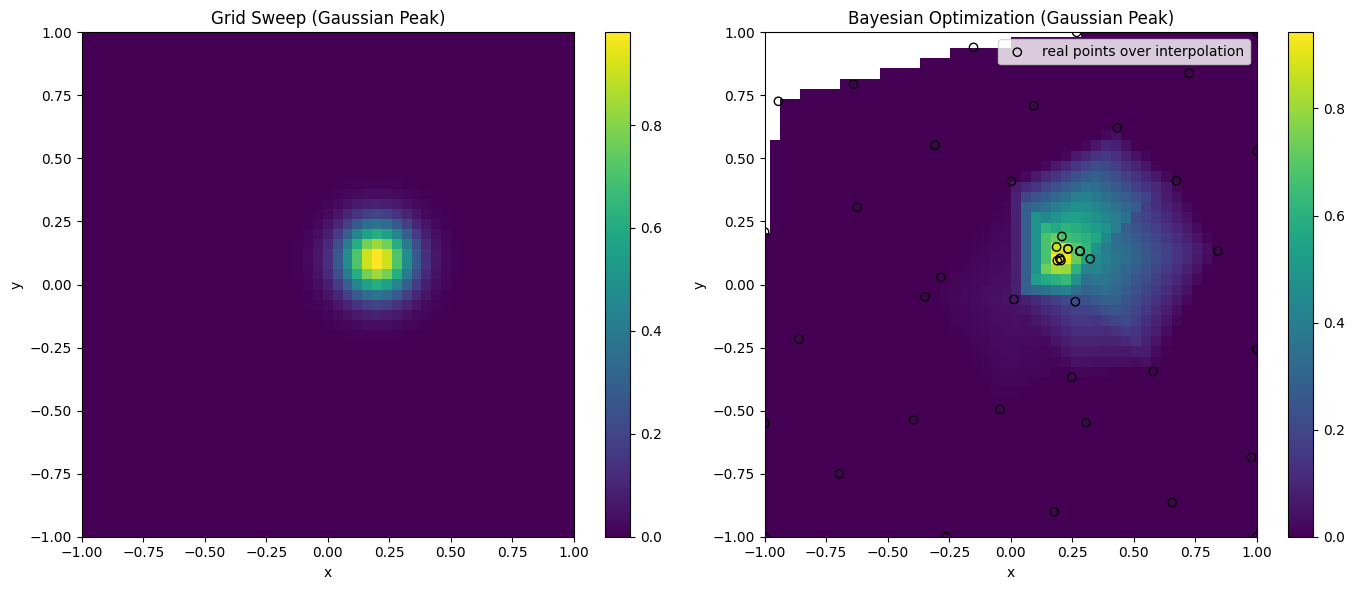

In [8]:
# Extract x, y, and z for plotting
x_vals = [p["a"] for p in suggested_params]
y_vals = [p["b"] for p in suggested_params]

# Create a grid sweep version (51 x 51 points)
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = np.exp(-((x_grid - 0.2) ** 2 + (y_grid - 0.1) ** 2) / (2 * 0.1 ** 2))

# Create interpolation for the scatter plot using scipy's griddata
x_interp = np.linspace(-1, 1, 50)
y_interp = np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_vals, y_vals), observed_z, (x_interp_grid, y_interp_grid), method='linear')

# Plotting the grid sweep and Bayesian optimization results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
ax[0].set_title("Grid Sweep (Gaussian Peak)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(c1, ax=ax[0])

# Scatter plot with interpolation for Bayesian optimization samples
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
ax[1].scatter(x_vals, y_vals, edgecolor='black', facecolor='none', label="real points over interpolation")
ax[1].set_title("Bayesian Optimization (Gaussian Peak)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].legend()
fig.colorbar(c2, ax=ax[1])

for ax in ax:
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)

plt.tight_layout()
plt.show()


# Benchmarking Configs Trial Rates 

In [ ]:
import time
import asyncio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

TRUE_PEAK_VALUE = 1.0  # The true peak value of the ZReader function
REPEATS = 3  # Number of times to repeat each batch size

async def run_async_experiment(batch_size, results):
    for _ in range(REPEATS):
        suggested_params = []
        observed_z = []
        best_result = {"params": None, "value": float("-inf")}

        start = time.perf_counter()
        async for params in bayesian_optimizer_iterator(
            z_reader, param_names, param_bounds,
            num_initial_samples=20, num_bo_samples=20, batch_size=batch_size, async_mode=True
        ):
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            suggested_params.append(params)
            observed_z.append(z_mean)
            if z_mean > best_result["value"]:
                best_result = {"params": params, "value": z_mean}

        end = time.perf_counter()
        elapsed_time = end - start
        error = abs(TRUE_PEAK_VALUE - best_result["value"])
        print(f"Batch size {batch_size}: Async time: {elapsed_time}, Error: {error}")

        results.append({
            "mode": "async",
            "batch_size": batch_size,
            "time": elapsed_time,
            "best_value": best_result["value"],
            "error": error
        })


async def main_async(results):
    for b_size in [1, 2, 3, 4, 5]:
        await run_async_experiment(b_size, results)


def run_sync_experiment(batch_size, results):
    for _ in range(REPEATS):
        suggested_params = []
        observed_z = []
        best_result = {"params": None, "value": float("-inf")}

        start = time.perf_counter()
        for params in bayesian_optimizer_iterator_sync(
            z_reader, param_names, param_bounds,
            num_initial_samples=20, num_bo_samples=20, batch_size=batch_size
        ):
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            suggested_params.append(params)
            observed_z.append(z_mean)
            if z_mean > best_result["value"]:
                best_result = {"params": params, "value": z_mean}

        end = time.perf_counter()
        elapsed_time = end - start
        error = abs(TRUE_PEAK_VALUE - best_result["value"])
        print(f"Batch size {batch_size}: Sync time: {elapsed_time}, Error: {error}")

        results.append({
            "mode": "sync",
            "batch_size": batch_size,
            "time": elapsed_time,
            "best_value": best_result["value"],
            "error": error
        })


def main_sync(results):
    for batch_size in [1, 2, 3, 4, 5]:
        run_sync_experiment(batch_size, results)


# Collect results
results = []
await main_async(results)
main_sync(results)

# Convert results to a pandas DataFrame
df = pd.DataFrame(results)

# Calculate mean and std for each metric
summary = df.groupby(['mode', 'batch_size']).agg(
    time_mean=('time', 'mean'),
    time_std=('time', 'std'),
    best_value_mean=('best_value', 'mean'),
    best_value_std=('best_value', 'std'),
    error_mean=('error', 'mean'),
    error_std=('error', 'std')
).reset_index()

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# Normalize time to trial rate (trials/second)
time_data = (summary.pivot(index='batch_size', columns='mode', values='time_mean') / 20) ** -1
error_data = summary.pivot(index='batch_size', columns='mode', values='error_mean')

# Bar plot for time (primary Y-axis)
indices = np.arange(len(time_data.index))
width = 0.35
cmap = plt.get_cmap("viridis")
async_color, sync_color = cmap(0.5), cmap(0.25)

bars_async = ax1.bar(indices - width / 2, time_data['async'], width, color=async_color, label='Async')
bars_sync = ax1.bar(indices + width / 2, time_data['sync'], width, color=sync_color, label='Sync')

ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Trial Rate (trials/s)", color="black")
ax1.set_title("Bayesian Optimization: Async vs Sync Performance")
ax1.set_xticks(indices)
ax1.set_xticklabels(time_data.index)
ax1.legend(loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Error bar for trial rate
ax1.errorbar(
    indices - width / 2, time_data['async'], 
    yerr=summary.query("mode == 'async'")["time_std"], 
    fmt="none", color="black", capsize=5
)
ax1.errorbar(
    indices + width / 2, time_data['sync'], 
    yerr=summary.query("mode == 'sync'")["time_std"], 
    fmt="none", color="black", capsize=5
)

# Line plot for error (secondary Y-axis)
ax2 = ax1.twinx()
ax2.plot(
    indices, error_data['async'], color="tab:red", marker="o", label="Async Error"
)
ax2.plot(
    indices, error_data['sync'], color="tab:orange", marker="o", label="Sync Error"
)
ax2.set_ylabel("Error", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Correctly compute trial rate mean and standard deviation
trial_rate_mean = 20 / summary.pivot(index="batch_size", columns="mode", values="time_mean")
trial_rate_std = (20 / summary.pivot(index="batch_size", columns="mode", values="time_mean") ** 2) * \
                 summary.pivot(index="batch_size", columns="mode", values="time_std")

# Clamp negative trial rate stds
trial_rate_std = np.clip(trial_rate_std, 0, None)

# Error data
error_mean = summary.pivot(index="batch_size", columns="mode", values="error_mean")
error_std = summary.pivot(index="batch_size", columns="mode", values="error_std")

# Plot time and error
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for trial rates
indices = np.arange(len(trial_rate_mean.index))
width = 0.35
cmap = plt.get_cmap("viridis")
async_color = cmap(0.5)
sync_color = cmap(0.25)

# Add bars
ax1.bar(
    indices - width / 2, trial_rate_mean["async"], width=width, color=async_color, label="Async"
)
ax1.bar(
    indices + width / 2, trial_rate_mean["sync"], width=width, color=sync_color, label="Sync"
)

# Add error bars for trial rates
ax1.errorbar(
    indices - width / 2, trial_rate_mean["async"], 
    yerr=trial_rate_std["async"], fmt="none", color="black", capsize=5
)
ax1.errorbar(
    indices + width / 2, trial_rate_mean["sync"], 
    yerr=trial_rate_std["sync"], fmt="none", color="black", capsize=5
)

# Set labels for primary y-axis
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Trial Rate (trials/s)", color="black")
ax1.set_title("20 Shots on goal BO")
ax1.set_xticks(indices)
ax1.set_xticklabels(trial_rate_mean.index)
ax1.legend(loc="upper left")
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Line plot for error (on secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(
    indices, error_mean["async"], color="tab:red", marker="o", label="Async Error"
)
ax2.plot(
    indices, error_mean["sync"], color="tab:orange", marker="o", label="Sync Error"
)

# Add error bars for error
ax2.errorbar(
    indices, error_mean["async"], 
    yerr=error_std["async"], fmt="none", color="tab:red", capsize=5
)
ax2.errorbar(
    indices, error_mean["sync"], 
    yerr=error_std["sync"], fmt="none", color="tab:orange", capsize=5
)

# Set labels for secondary y-axis
ax2.set_ylabel("Error", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.legend(loc="upper right")

# Finalize the layout
plt.tight_layout()
plt.show()


# SCRAP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from ax import optimize
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition import qNegIntegratedPosteriorVariance
import random
from typing import Tuple
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from ax.utils.common.logger import get_logger

logger = get_logger(__name__)
from gpytorch.settings import max_cg_iterations


def bayesian_optimizer(num_initial_samples: int = 10, num_bo_samples: int = 100, epsilon: float = 1e-3, patience: int = 15, refit_every: int = 10, exploit_ratio: float = 0.9, seed: int = 1):
    """
    Bayesian optimization function that yields new points to sample.

    Args:
        num_initial_samples (int): Number of initial Sobol samples for exploration.
        num_bo_samples (int): Maximum number of Bayesian optimization samples to be taken after the initial exploration.
        epsilon (float): Convergence threshold.
        patience (int): Number of iterations without improvement to allow before stopping early.
        refit_every (int): Number of iterations after which the GP model is refit.
        exploit_ratio (float): Proportion of times exploitation (GPEI) is used compared to exploration (qNIPV).
        seed (int): Random seed for reproducibility.
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    # Setting up the Bayesian optimizer using Ax with a custom generation strategy.
    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(model=Models.GPEI, num_trials=-1),
        ]
    )

    ax_client = AxClient(generation_strategy=generation_strategy)
    ax_client.create_experiment(
        name="2d_gaussian_peak_optimization",
        parameters=[
            {"name": "x", "type": "range", "bounds": [-1.0, 1.0]},
            {"name": "y", "type": "range", "bounds": [-1.0, 1.0]},
        ],
        objective_name="z",
        minimize=False,  # Set True if you want to minimize the objective
    )

    # Lists to store sampled points and their objective values.
    z_samples = []
    x_samples = []
    y_samples = []

    # Initial exploration with Sobol sampling.
    for _ in range(num_initial_samples):
        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

    # Define and fit the GP model.
    x_y_samples_tensor = torch.tensor(np.column_stack([x_samples, y_samples])).double()
    z_samples_tensor = torch.tensor(z_samples).double().unsqueeze(-1)
    gp_model = SingleTaskGP(x_y_samples_tensor, z_samples_tensor)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)

    # Bayesian optimization loop with convergence criteria.
    best_value = None
    no_improvement_counter = 0

    for i in range(num_bo_samples):
        # Randomly decide whether to use exploitation (GPEI) or exploration (qNIPV)
        rand_value = random.random()
        if rand_value < exploit_ratio:
            logger.info("Using GPEI for exploitation")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
        else:
            logger.info("Using qNIPV for exploration")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 10},
            }

        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

        x_y_samples_tensor = torch.tensor(np.column_stack([x_samples, y_samples])).double()
        z_samples_tensor = torch.tensor(z_samples).double().unsqueeze(-1)

        if i % refit_every == 0 or i == num_bo_samples - 1:
            gp_model.set_train_data(x_y_samples_tensor, z_samples_tensor, strict=False)
            with max_cg_iterations(50):  # Use fewer iterations for solving GP equations
                fit_gpytorch_model(mll)
                
        if rand_value < exploit_ratio:
            if best_value is None or z > best_value + epsilon:
                best_value = z
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

        if no_improvement_counter >= patience:
            print(f"Stopping early after {i + 1} iterations due to lack of improvement.")
            break


In [ ]:
# Use the Bayesian optimizer to get new points.
x_samples, y_samples, z_samples = [], [], []
for x_sample, y_sample, z in bayesian_optimizer():
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)

In [ ]:
# Create a grid sweep version (51 x 51 points).
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = np.exp(-((x_grid - 0.2) ** 2 + (y_grid - 0.1) ** 2) / (2 * 0.1 ** 2))



# Create interpolation for the scatter plot using scipy's griddata.
x_interp = np.linspace(-1, 1, 50)
y_interp = np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_samples, y_samples), z_samples, (x_interp_grid, y_interp_grid), method='linear')

# Plotting the grid sweep version.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version.
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
ax[0].set_title("Grid Sweep (Gaussian Peak)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(c1, ax=ax[0])

# Scatter plot with interpolation for Bayesian optimization samples.
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
ax[1].scatter(x_samples, y_samples, edgecolor='black', facecolor='none')
ax[1].set_title("Bayesian Optimization (Gaussian Peak)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
fig.colorbar(c2, ax=ax[1])

plt.tight_layout()
plt.show()